In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('data/ecommerce.csv', encoding='cp1252', parse_dates=['InvoiceDate'])

# I'll only keep UK sales
df = df[df.Country == 'United Kingdom']

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495478 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    495478 non-null  object        
 1   StockCode    495478 non-null  object        
 2   Description  494024 non-null  object        
 3   Quantity     495478 non-null  int64         
 4   InvoiceDate  495478 non-null  datetime64[ns]
 5   UnitPrice    495478 non-null  float64       
 6   CustomerID   361878 non-null  float64       
 7   Country      495478 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 34.0+ MB


In [5]:
user_df = pd.DataFrame(df['CustomerID'].unique())
user_df.columns = ['CustomerID']

In [6]:
# Get the latest purchase date for each customer and pass it to a df
max_purchase = df.groupby('CustomerID').InvoiceDate.max().reset_index()
max_purchase.columns = ['CustomerID', 'MaxPurchaseDate']
max_purchase['MaxPurchaseDate'] = max_purchase['MaxPurchaseDate'].dt.date

### Frequency

In [7]:
# for the purpose of this project, I'll consider the last day 
# in the dataset as 'today' to calculate the Recency

max_purchase['Recency'] = (
    max_purchase['MaxPurchaseDate'].max() - max_purchase['MaxPurchaseDate']).dt.days 

In [8]:
# Now, merge the dataframe with the user_df to get the Recency score for each customer
user_df = pd.merge(user_df, max_purchase[['CustomerID', 'Recency']], on='CustomerID')
user_df.head()

,CustomerID,Recency
0,17850.0,302
1,13047.0,31
2,13748.0,95
3,15100.0,330
4,15291.0,25


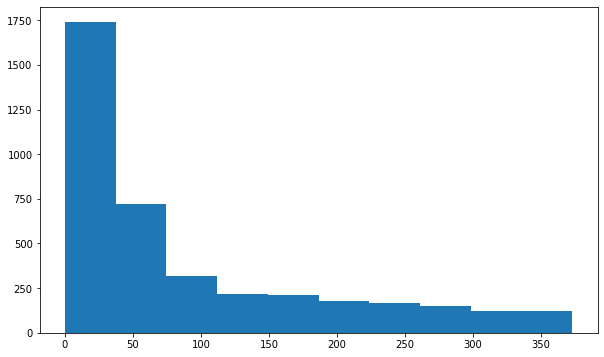

In [9]:
# plot a histogram of Recency
fig = plt.figure(figsize=(10, 6))
plt.hist(user_df['Recency']);

In [10]:
# Get an overview of Recency
user_df['Recency'].describe()

count    3950.000000
mean       91.323038
std       100.236848
min         0.000000
25%        16.000000
50%        50.000000
75%       143.000000
max       373.000000
Name: Recency, dtype: float64

Now, we'll apply K-means clustering to assign a recency score. To find out how many clusters we need, we'll apply the Elbow Method

Text(0.5, 0, 'Number of clusters')

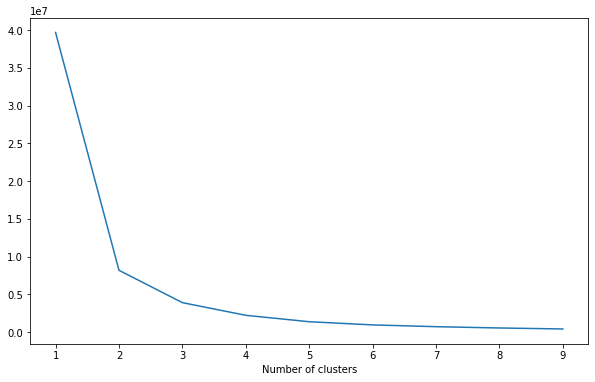

In [11]:
from sklearn.cluster import KMeans

sse = {}
recency = user_df[['Recency']]

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=100)
    kmeans.fit(recency)
    recency['clusters'] = kmeans.labels_
    sse[k] = kmeans.inertia_

keys = list(sse.keys())
values = list(sse.values())

# plot the inertia graph
plt.figure(figsize=(10, 6))
plt.plot(keys, values)
plt.xlabel('Number of clusters')

The number of optimal clusters seems to be 3

In [12]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(user_df[['Recency']])

user_df['RecencyCluster'] = kmeans.predict(user_df[['Recency']])

In [13]:
def order_clusters(cluster, target, df, ascending):
    new_cluster = 'new' + cluster
    
    temp = df.groupby(cluster)[target].mean().reset_index()
    temp = temp.sort_values(by=target, ascending=ascending).reset_index(drop=True)
    temp['index'] = temp.index
    
    cluster_df = pd.merge(df, temp[[cluster, 'index']], on=cluster)
    cluster_df = cluster_df.drop([cluster], axis=1)
    cluster_df = cluster_df.rename(columns={'index':cluster})
    
    return cluster_df

In [14]:
user_df = order_clusters('RecencyCluster', 'Recency', user_df, False)

In [15]:
# Now every customer has been assigned to a cluster based on their Recency
# and the clusters are ordered from lowest to highest
user_df.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,564.0,294.221631,45.631494,225.0,256.0,287.0,326.75,373.0
1,741.0,153.245614,38.393329,92.0,119.0,154.0,185.00,222.0
2,2645.0,30.710775,24.881806,0.0,9.0,24.0,50.00,91.0


### Frequency

In [16]:
frequency = df.groupby('CustomerID')['InvoiceDate'].count().reset_index()
frequency.columns = ['CustomerID', 'Frequency']

In [17]:
user_df = pd.merge(user_df, frequency, on='CustomerID')
user_df

,CustomerID,Recency,RecencyCluster,Frequency
0,17850.0,302,0,312
1,15100.0,330,0,6
2,18074.0,373,0,13
3,16250.0,261,0,24
4,13747.0,373,0,1
...,...,...,...,...
3945,13210.0,93,1,22
3946,13889.0,92,1,15
3947,15488.0,92,1,2
3948,18222.0,92,1,19


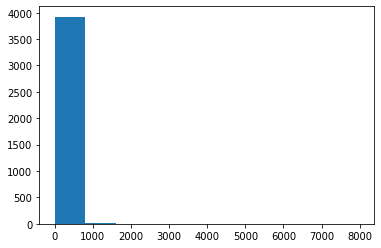

In [35]:
# Plot the distribution 
plt.hist(user_df['Frequency']);

In [19]:
# Assign a frequency cluster for each user
kmeans.fit(user_df[['Frequency']])
user_df['FrequencyCluster'] = kmeans.predict(user_df[['Frequency']])

# order the clusters
user_df = order_clusters('FrequencyCluster', 'Frequency', user_df, True)

# describe the clusters
user_df.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3681.0,58.325183,58.393018,1.0,16.0,36.0,84.00,272.0
1,266.0,486.578947,311.017362,273.0,316.0,393.0,518.25,2782.0
2,3.0,5917.666667,1805.062418,4642.0,4885.0,5128.0,6555.50,7983.0


Just like with the recency clusters, a high frequency indicates a better customer.

### Monetary Value (Revenue)

In [41]:
# Calculate revenue for each customer
df['Revenue'] = df['UnitPrice']*df['Quantity']
revenue = df.groupby('CustomerID')['Revenue'].sum().reset_index()

# Merge the revenue with users dataframe
user_df = pd.merge(user_df, revenue, on='CustomerID')

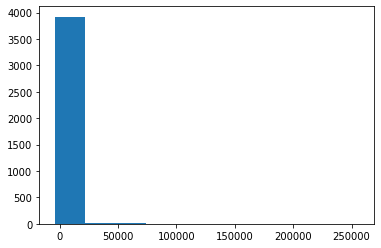

In [46]:
# Plot the data
plt.hist(user_df['Revenue']);

In [ ]:
# Cluster the users by Revenue
kmeans = KMeans(n_clusters=3)

kmeans.fit(user_df[['Revenue']])
kmeans.fit

In [54]:
def rfm_cluster(df, cluster_variable, n_clusters, ascending):
    
    # Create and fit the k-means 
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(df[[cluster_variable]])
    
    # predict the cluster and pass it to the dataframe
    df[cluster_variable + 'Cluster'] = kmeans.predict(df[[cluster_variable]])
    
    # order the cluster numbers
    df = order_clusters(cluster_variable + 'Cluster', cluster_variable, df, ascending)
    
    return df

In [55]:
rfm_cluster(user_df, 'Revenue', 4, True)

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,17850.0,302,0,312,1,5288.63,1
1,14688.0,7,2,359,1,5107.38,1
2,14527.0,2,2,1011,1,7711.38,1
3,13767.0,2,2,399,1,16945.71,1
4,15513.0,31,2,314,1,14520.08,1
...,...,...,...,...,...,...,...
3945,15488.0,92,1,2,0,91.32,0
3946,18222.0,92,1,19,0,443.00,0
3947,13244.0,92,1,27,0,121.74,0
3948,17450.0,8,2,351,1,187482.17,3


In [56]:
user_df.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,3687.0,907.254414,921.910820,-4287.63,263.115,572.56,1258.220,4314.72
1,2.0,221960.330000,48759.481478,187482.17,204721.250,221960.33,239199.410,256438.49
2,27.0,43070.445185,15939.249588,25748.35,28865.490,36351.42,53489.790,88125.38
3,234.0,7760.699530,3637.173671,4330.67,5161.485,6549.38,9142.305,21535.90


## Overall RFM Score

In [59]:
user_df['OverallScore'] = user_df['RecencyCluster'] + user_df['FrequencyCluster'] + user_df['RevenueCluster']
user_df.groupby('OverallScore')[['Recency', 'Frequency', 'Revenue']].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,294.430357,22.553571,317.525214
1,153.545082,37.989071,607.352283
2,33.668132,69.647473,1058.231861
3,21.414634,404.837398,2836.707480
4,55.875000,162.500000,49643.021875
5,16.372881,240.449153,12457.208390
6,11.071429,652.571429,8927.348889


We can arbitrarily assign labels for the different Overall Score clusters for the sake of simplicity

- 0 - 1: **Low**
- 2 - 4: **Medium**
- 5 - 6: **High**

In [61]:
# Create the Segment variable based on the OverallScore
x = user_df['OverallScore']
conditions = [x<2, x<5]
choices = ['Low', 'Medium']

user_df['Segment'] = np.select(conditions, choices, default='High')

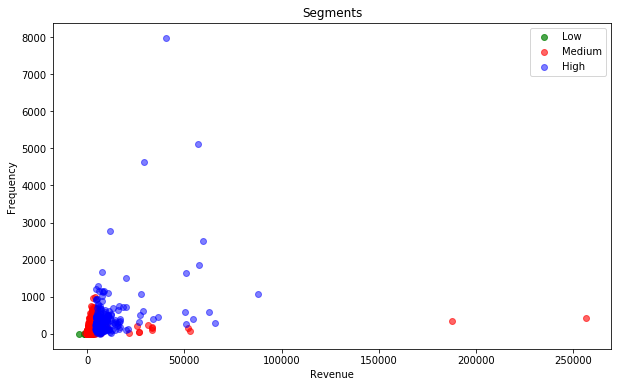

In [113]:
fig = plt.figure(figsize=(10, 6))
plt.title('Segments')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
    
plt.scatter(x=user_df.query("Segment == 'Low'")['Revenue'],
            y= user_df.query("Segment == 'Low'")['Frequency'],
            c='green', alpha=0.7, label='Low')

plt.scatter(x=user_df.query("Segment == 'Medium'")['Revenue'],
            y=user_df.query("Segment == 'Medium'")['Frequency'],
            c='red', alpha=0.6, label='Medium')

plt.scatter(x=user_df.query("Segment == 'High'")['Revenue'],
            y=user_df.query("Segment == 'High'")['Frequency'],
            c='blue', alpha=0.5, label='High')

plt.legend();

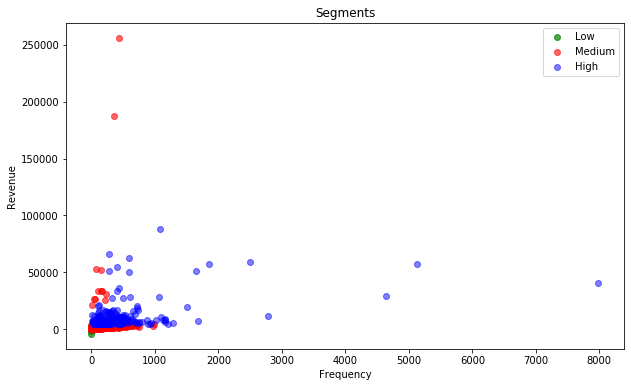

In [114]:
fig = plt.figure(figsize=(10, 6))
plt.title('Segments')
plt.xlabel('Frequency')
plt.ylabel('Revenue')
    
plt.scatter(x=user_df.query("Segment == 'Low'")['Frequency'],
            y= user_df.query("Segment == 'Low'")['Revenue'],
            c='green', alpha=0.7, label='Low')

plt.scatter(x=user_df.query("Segment == 'Medium'")['Frequency'],
            y=user_df.query("Segment == 'Medium'")['Revenue'],
            c='red', alpha=0.6, label='Medium')

plt.scatter(x=user_df.query("Segment == 'High'")['Frequency'],
            y=user_df.query("Segment == 'High'")['Revenue'],
            c='blue', alpha=0.5, label='High')

plt.legend();

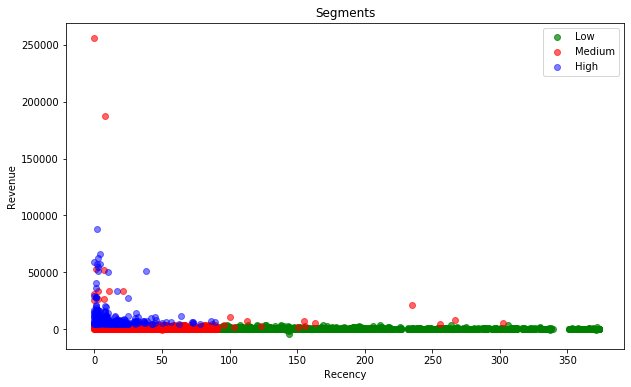

In [115]:
fig = plt.figure(figsize=(10, 6))
plt.title('Segments')
plt.xlabel('Recency')
plt.ylabel('Revenue')

plt.scatter(x=user_df.query("Segment == 'Low'")['Recency'],
            y= user_df.query("Segment == 'Low'")['Revenue'],
            c='green', alpha=0.7, label='Low')

plt.scatter(x=user_df.query("Segment == 'Medium'")['Recency'],
            y=user_df.query("Segment == 'Medium'")['Revenue'],
            c='red', alpha=0.6, label='Medium')

plt.scatter(x=user_df.query("Segment == 'High'")['Recency'],
            y=user_df.query("Segment == 'High'")['Revenue'],
            c='blue', alpha=0.5, label='High')

plt.legend();


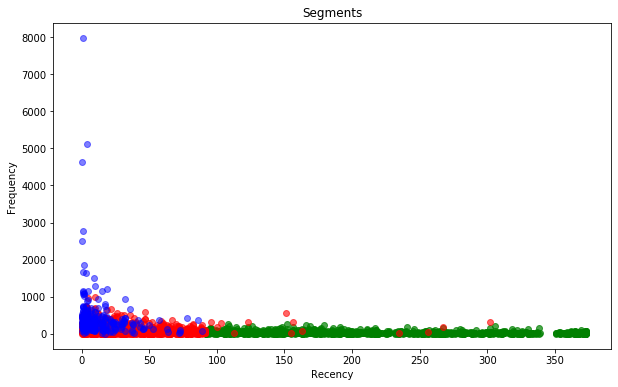

In [101]:
fig = plt.figure(figsize=(10, 6))
plt.title('Segments')
plt.xlabel('Recency')
plt.ylabel('Frequency')
    
plt.scatter(x=user_df.query("Segment == 'Low'")['Recency'],
            y= user_df.query("Segment == 'Low'")['Frequency'],
            c='green', alpha=0.7)

plt.scatter(x=user_df.query("Segment == 'Medium'")['Recency'],
            y=user_df.query("Segment == 'Medium'")['Frequency'],
            c='red', alpha=0.6)

plt.scatter(x=user_df.query("Segment == 'High'")['Recency'],
            y=user_df.query("Segment == 'High'")['Frequency'],
            c='blue', alpha=0.5);

We can see that the different segments behave differently, we can apply different strategies to the different groups